# Single Factorization

Bloqs for the single-factorized chemistry Hamiltonian in second quantization.

Recall that for the single factorized Hamiltonian we have
$$
    H = \sum_{pq}T'_{pq} a_p^\dagger a_q + \frac{1}{2} \sum_l \left(\sum_{pq}
W_{pq}^{(l)} a_p^\dagger a_q\right)^2.
$$
where $\sum_l^L W_{pq}^{(l)} W_{rs}^{(l)} = (pq|rs)$ are the standard chemist's
electron repulsion integrals.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `SingleFactorizationOneBody`
Block encoding of single factorization one-body Hamiltonian.

Implements inner "half" of Fig. 15 in the reference. This block encoding is
applied twice (with a reflection around the inner state preparation
registers) to implement (roughly) the square of this one-body operator.

#### Parameters
 - `num_aux`: Dimension of auxiliary index for single factorized Hamiltonian. Called $L$ in the reference.
 - `num_spin_orb`: The number of spin orbitals. Typically called $N$.
 - `num_bits_state_prep`: The number of bits of precision for coherent alias sampling. Called $\aleph$ in the reference.
 - `num_bits_rot_aa`: Number of bits of precision for rotations for amplitude amplification in uniform state preparation. Called $b_r$ in the reference.
 - `is_adjoint`: Whether this bloq is daggered or not. This affects the QROM cost.
 - `kp1`: QROAM blocking factor for data prepared over l (auxiliary) index. Defaults to 1 (i.e. QROM).
 - `kp1`: QROAM blocking factor for data prepared over pq indicies. Defaults to 1 (i.e.) QROM.
 - `kp1_inv`: QROAM blocking factor for inverting data prepared over l (auxiliary) index.
 - `kp1_inv`: QROAM blocking factor for inverting of data prepared over pq. 

#### Registers
 - `succ_l`: Flag for success of l state preparation.
 - `l_ne_zero`: Flag for l != 0.
 - `succ_pq`: Flag for success of pq.
 - `l`: register to store L values for auxiliary index.
 - `p`: spatial orbital index. range(0, num_spin_orb // 2)
 - `q`: spatial orbital index. range(0, num_spin_orb // 2)
 - `rot_aa`: Qubit to rotate for amplitude amplification for state preparation.
 - `swap_pq`: Qubit for controlling swaps over p and q registers.
 - `spin`: Qubit for controlling swaps over system registers.
 - `sys`: The system registers. 

Refererences:
    [Even More Efficient Quantum Computations of Chemistry Through Tensor
        Hypercontraction](https://arxiv.org/abs/2011.03494) Fig. 15 page 43.

In [2]:
from qualtran.bloqs.chemistry.sf.single_factorization import SingleFactorizationOneBody

### Example Instances

In [3]:
num_aux = 50
num_bits_state_prep = 12
num_bits_rot_aa = 7
num_spin_orb = 10
sf_one_body = SingleFactorizationOneBody(
    num_aux=num_aux,
    num_spin_orb=num_spin_orb,
    num_bits_state_prep=num_bits_state_prep,
    num_bits_rot_aa=num_bits_rot_aa,
    is_adjoint=False,
)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([sf_one_body],
           ['`sf_one_body`'])

### Call Graph

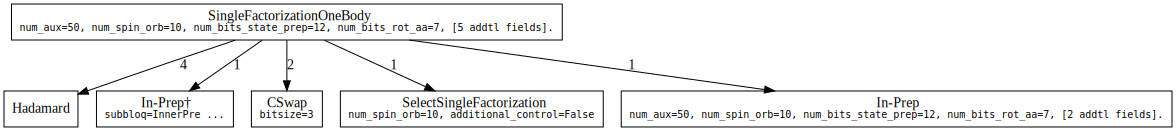

#### Counts totals:
 - `Adjoint(subbloq=InnerPrepareSingleFactorization(num_aux=50, num_spin_orb=10, num_bits_state_prep=12, num_bits_rot_aa=7, kp1=1, kp2=1))`: 1
 - `CSwap(bitsize=3)`: 2
 - `Hadamard()`: 4
 - `InnerPrepareSingleFactorization(num_aux=50, num_spin_orb=10, num_bits_state_prep=12, num_bits_rot_aa=7, kp1=1, kp2=1)`: 1
 - `SelectSingleFactorization(num_spin_orb=10, additional_control=False)`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
sf_one_body_g, sf_one_body_sigma = sf_one_body.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(sf_one_body_g)
show_counts_sigma(sf_one_body_sigma)

## `SingleFactorizationBlockEncoding`
Block encoding of single factorization Hamiltonian.

Implements Fig. 15 in the reference.

#### Parameters
 - `num_spin_orb`: The number of spin orbitals. Typically called N.
 - `num_aux`: Dimension of auxiliary index for single factorized Hamiltonian. Called $L$ in the reference.
 - `num_bits_state_prep`: The number of bits of precision for coherent alias sampling. Called $\aleph$ in the reference.
 - `num_bits_rot_aa_outer`: Number of bits of precision for rotations for amplitude amplification in outer uniform state preparation. Called $b_r$ in the reference.
 - `num_bits_rot_aa_inner`: Number of bits of precision for rotations for amplitude amplification in inner uniform state preparation. Called $b_r$ in the reference.
 - `kp1`: QROAM blocking factor for data prepared over l (auxiliary) index. Defaults to 1 (i.e. QROM).
 - `kp1`: QROAM blocking factor for data prepared over pq indicies. Defaults to 1 (i.e.) QROM.
 - `kp1_inv`: QROAM blocking factor for inverting the data prepared over l (auxiliary) index.
 - `kp1_inv`: QROAM blocking factor for inverting the data prepared over pq. 

#### Registers
 - `ctrl`: Control registers for state preparation.
 - `l`: register to store L values for auxiliary index.
 - `p`: spatial orbital index. range(0, num_spin_orb // 2)
 - `q`: spatial orbital index. range(0, num_spin_orb // 2)
 - `rot_aa`: Qubit to rotate for amplitude amplification for state preparation.
 - `swap_pq`: Qubit for controlling swaps over p and q registers.
 - `spin`: Qubit for controlling swaps over system registers.
 - `sys`: The system registers. 

Refererences:
    [Even More Efficient Quantum Computations of Chemistry Through Tensor
        Hypercontraction](https://arxiv.org/abs/2011.03494) Fig 15, page 43.

In [6]:
from qualtran.bloqs.chemistry.sf.single_factorization import SingleFactorizationBlockEncoding

### Example Instances

In [7]:
num_spin_orb = 10
num_aux = 50
num_bits_state_prep = 12
sf_block_encoding = SingleFactorizationBlockEncoding(
    num_spin_orb=num_spin_orb,
    num_aux=num_aux,
    num_bits_state_prep=num_bits_state_prep,
    num_bits_rot_aa_outer=7,
    num_bits_rot_aa_inner=7,
)

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([sf_block_encoding],
           ['`sf_block_encoding`'])

### Call Graph

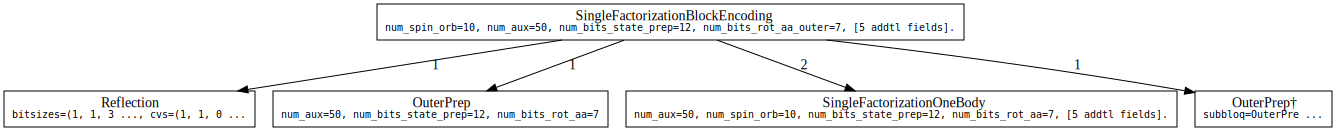

#### Counts totals:
 - `Adjoint(subbloq=OuterPrepareSingleFactorization(num_aux=50, num_bits_state_prep=12, num_bits_rot_aa=7))`: 1
 - `OuterPrepareSingleFactorization(num_aux=50, num_bits_state_prep=12, num_bits_rot_aa=7)`: 1
 - `Reflection(bitsizes=(1, 1, 3, 3, 1, 1), cvs=(1, 1, 0, 0, 0, 0))`: 1
 - `SingleFactorizationOneBody(num_aux=50, num_spin_orb=10, num_bits_state_prep=12, num_bits_rot_aa=7, is_adjoint=False, kp1=1, kp2=1, kp1_inv=1, kp2_inv=1)`: 2

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
sf_block_encoding_g, sf_block_encoding_sigma = sf_block_encoding.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(sf_block_encoding_g)
show_counts_sigma(sf_block_encoding_sigma)